测试数据和训练数据分组，数据分batch

In [1]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('emd_trainX_1024_10c')
    train_ylabel = load('emd_trainY_1024_10c')
    # 验证集
    val_xdata = load('emd_valX_1024_10c')
    val_ylabel = load('emd_valY_1024_10c')
    # 测试集
    test_xdata = load('emd_testX_1024_10c')
    test_ylabel = load('emd_testY_1024_10c')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 32
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

In [2]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

50
14
7


定义EMD-CNN-Transformer分类网络架构

In [7]:
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer
# 定义 EMDCNNTransformer 分类模型

class EMDCNNTransformer(nn.Module):
    def __init__(self, batch_size, input_channels, conv_archs, output_dim, hidden_dim, num_layers, num_heads, dropout_rate=0.5):
        """
        分类任务  params:
        batch_size       : 批次量大小
        input_channels            : CNN输入维度(通道数)
        conv_archs                : cnn 网络结构
        output_dim                : 输出的维度,类别数
        hidden_dim                : 注意力维度
        num_layers                : Transformer编码器层数
        num_heads                 : 多头注意力头数
        dropout_rate     : 随机丢弃神经元的概率


        """
        super().__init__()
        # 批次量大小
        self.batch_size = batch_size
       # 批次量大小
        self.batch_size = batch_size
        # cnn参数
        self.conv_arch = conv_archs # 网络结构
        self.input_channels = input_channels # 输入通道数
        self.cnn_features = self.make_layers()

        # Transformer编码器
        self.hidden_dim = hidden_dim
        # Time Transformer layers
        self.transformer = TransformerEncoder(
            TransformerEncoderLayer(conv_archs[-1][-1], num_heads, hidden_dim, dropout=0.5, batch_first=True),
            num_layers
        )

        # 序列平局池化
        self.avgpool = nn.AdaptiveAvgPool1d(1)

         # 定义全连接层
        self.classifier = nn.Linear(conv_archs[-1][-1], output_dim)
    
     # CNN卷积池化结构
    def make_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_arch:
            for _ in range(num_convs):
                layers.append(nn.Conv1d(self.input_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                self.input_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)
    
    def forward(self, input_seq): 
        # 数据预处理
        # 注意：这里是 把数据进行了堆叠 把一个7*1024 的矩阵 进行 划分堆叠成形状为 56 * 128， 就使输入序列的长度降下来了
        input_seq = input_seq.view(self.batch_size, -1, 128) 
       
        # CNN 卷积池化
        # CNN 网络输入[batch,dim, seq_length]
        cnn_features = self.cnn_features(input_seq) # torch.Size([32, 128, 16])

        # 调换维度[B, D, L] --> [B, L, D]
        cnn_features = cnn_features.permute(0,2,1)
        # Time-Transformer 处理
        # 在PyTorch中，transformer模型的性能与batch_first参数的设置相关。
        # 当batch_first为True时，输入的形状应为(batch, sequence, feature)，这种设置在某些情况下可以提高推理性能。
        transformer_output = self.transformer(cnn_features)  #  torch.Size([64, 16, 128])
        # 序列平均池化操作
        output_avgpool = self.avgpool(transformer_output.transpose(1, 2))  #  torch.Size([64, 1, 128])
        output_avgpool = output_avgpool.reshape(self.batch_size, -1)  #  torch.Size([64, 128])
        output = self.classifier(output_avgpool) # torch.Size([64, 10]  # 仅使用最后一个时间步的输出   
        return output


输入数据的形状是
 1. print(seq.size(), labels.size()) 
 2. torch.Size([32, 7, 1024])    torch.Size([32])

In [9]:
# 定义模型参数
# batch_size = 32
input_dim = 7 *8   # 输入维度为7个分量  把一个7*1024 的矩阵 进行 划分堆叠成形状为 56 * 128， 就使输入序列的长度降下来了
# cnn 参数
conv_archs = ((1, 64), (1, 128))   # CNN 层卷积池化结构  类似VGG
# Transformer参数
hidden_dim = 128  # 注意力维度
output_dim  = 10  # 输出维度 十分类
num_layers = 2   # 编码器层数
num_heads = 4   # 多头注意力头数
output_dim = 10

model = EMDCNNTransformer(batch_size, input_dim, conv_archs, output_dim, hidden_dim, num_layers, num_heads)  
# 定义损失函数和优化函数 
loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss
learn_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

 10752
    64
 24576
   128
 49152
   384
 16384
   128
 16384
   128
 16384
   128
   128
   128
   128
   128
 49152
   384
 16384
   128
 16384
   128
 16384
   128
   128
   128
   128
   128
  1280
    10
______
235978


In [5]:
print(model)

EMDCNNTransformer(
  (cnnfeatures): Sequential(
    (0): Conv1d(56, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=

Epoch:  1 train_Loss: 1.59094765 train_Accuracy:0.3356
Epoch:  1 val_Loss:1.17726980,  validate_Acc:0.5714
Epoch:  2 train_Loss: 0.93974441 train_Accuracy:0.6244
Epoch:  2 val_Loss:0.65795971,  validate_Acc:0.7076
Epoch:  3 train_Loss: 0.54866080 train_Accuracy:0.8187
Epoch:  3 val_Loss:0.34336663,  validate_Acc:0.8817
Epoch:  4 train_Loss: 0.24645440 train_Accuracy:0.9375
Epoch:  4 val_Loss:0.21440408,  validate_Acc:0.9442
Epoch:  5 train_Loss: 0.16961463 train_Accuracy:0.9487
Epoch:  5 val_Loss:0.17462485,  validate_Acc:0.9509
Epoch:  6 train_Loss: 0.14611543 train_Accuracy:0.9563
Epoch:  6 val_Loss:0.17964523,  validate_Acc:0.9308
Epoch:  7 train_Loss: 0.21480479 train_Accuracy:0.9313
Epoch:  7 val_Loss:0.29691553,  validate_Acc:0.9174
Epoch:  8 train_Loss: 0.21148357 train_Accuracy:0.9363
Epoch:  8 val_Loss:0.23790830,  validate_Acc:0.9085
Epoch:  9 train_Loss: 0.14586349 train_Accuracy:0.9525
Epoch:  9 val_Loss:0.09867252,  validate_Acc:0.9754
Epoch: 10 train_Loss: 0.08631218 trai

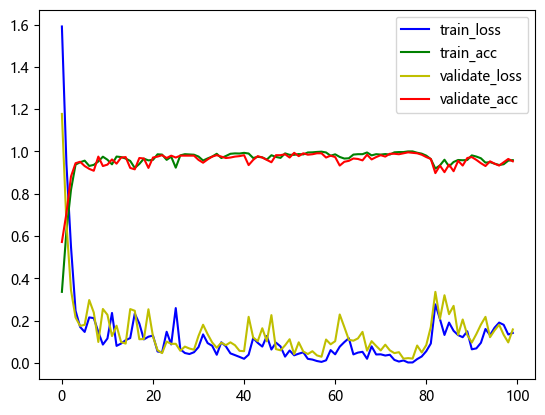

best_accuracy : 0.9955357142857143


In [10]:
# 训练模型
# 训练模型
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader):
    model = model.to(device)
    # 样本长度
    train_size = len(train_loader) * batch_size
    val_size = len(val_loader) * batch_size

    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model

    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        # 训练
        model.train()

        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # print(seq.size(), labels.size()) torch.Size([32, 7, 1024]) torch.Size([32])
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 对模型输出进行softmax操作，得到概率分布
            probabilities = F.softmax(y_pred, dim=1)
            # 得到预测的类别
            predicted_labels = torch.argmax(probabilities, dim=1)
            # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
            correct_epoch += (predicted_labels == labels).sum().item()
            # 损失计算
            loss = loss_function(y_pred, labels)
            loss_epoch += loss.item()
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算准确率
        train_Accuracy  = correct_epoch/train_size 
        train_loss.append(loss_epoch/train_size)
        train_acc.append(train_Accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_Accuracy:4.4f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            loss_validate = 0.
            correct_validate = 0
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 对模型输出进行softmax操作，得到概率分布
                probabilities = F.softmax(pre, dim=1)
                # 得到预测的类别
                predicted_labels = torch.argmax(probabilities, dim=1)
                # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
                correct_validate += (predicted_labels == label).sum().item()
                loss = loss_function(pre, label)
                loss_validate += loss.item()
            # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            val_accuracy = correct_validate/val_size 
            print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
            validate_loss.append(loss_validate/val_size)
            validate_acc.append(val_accuracy)
            # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model# 更新最佳模型的参数

    
    # 保存最后的参数
    # torch.save(model, 'final_model_emd_cnn_transformer.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_emd_cnn_transformer.pt')
   
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 lable 
    print("best_accuracy :", best_accuracy)



# batch_size = 32
epochs = 50
# 模型训练
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader)

In [11]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 得出每一类的分类准确率
model = torch.load('best_model_emd_cnn_transformer.pt')
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        22
           1     0.7000    1.0000    0.8235        21
           2     0.7000    0.5000    0.5833        14
           3     0.6774    1.0000    0.8077        21
           4     0.9615    1.0000    0.9804        25
           5     0.8636    0.9500    0.9048        20
           6     0.9643    1.0000    0.9818        27
           7     0.9130    0.6774    0.7778        31
           8     0.8261    0.7917    0.8085        24
           9     1.0000    0.4737    0.6429        19

    accuracy                         0.8527       224
   macro avg     0.8606    0.8393    0.8311       224
weighted avg     0.8714    0.8527    0.8449       224



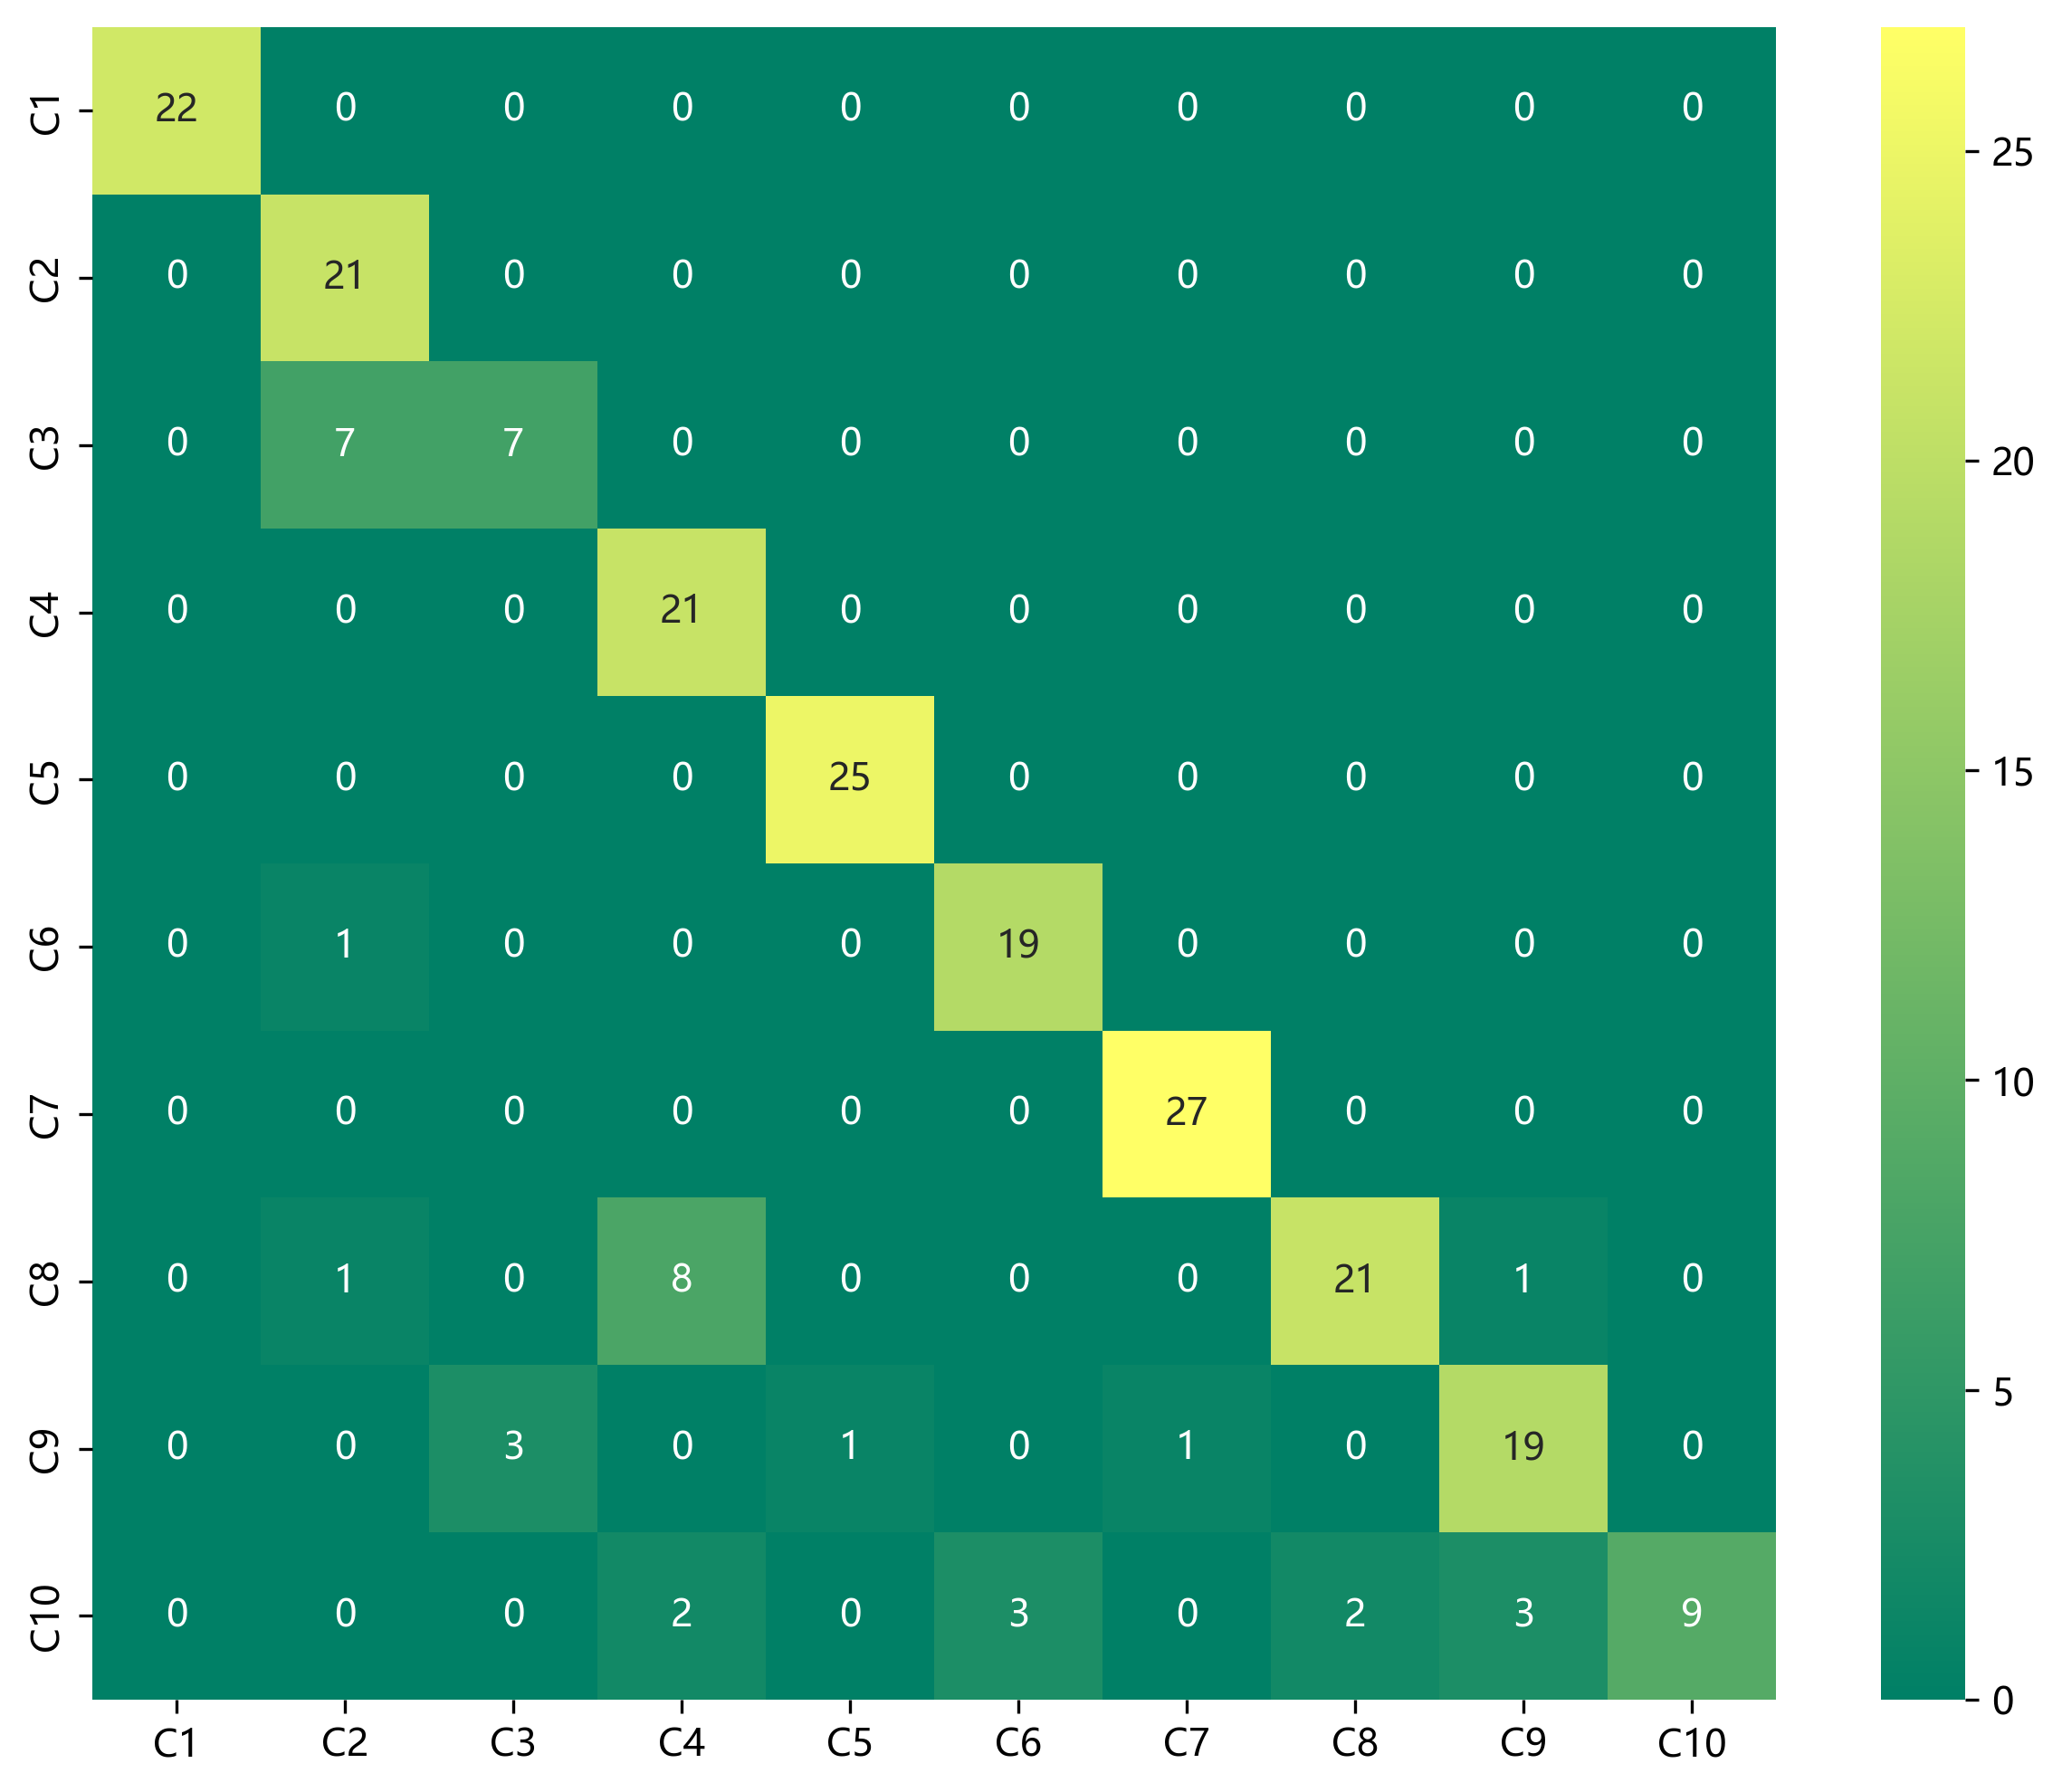

In [12]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
    5: "C6",6: "C7",7: "C8",8: "C9",9: "C10",
}

# 绘制混淆矩阵
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='summer')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
plt.show()